# Gensim Word2Vec

# Briefing about Word2Vec:

<img src="http://mccormickml.com/assets/word2vec/skip_gram_net_arch.png" alt="drawing" width="550"/>

[[1]](#References:)


## Purpose of the tutorial:
As I said before, this tutorial focuses on the right use of the Word2Vec package from the Gensim libray; therefore, I am not going to explain the concepts and ideas behind Word2Vec here. I am simply going to give a very brief explanation, and provide you with links to good, in depth tutorials.

## Brief explanation:

Word2Vec was introduced in two [papers](#Material-for-more-in-depths-understanding:) between September and October 2013, by a team of researchers at Google. Along with the papers, the researchers published their implementation in C. The Python implementation was done soon after the 1st paper, by [Gensim](https://radimrehurek.com/gensim/index.html). 

The underlying assumption of Word2Vec is that two words sharing similar contexts also share a similar meaning and consequently a similar vector representation from the model. For instance: "dog", "puppy" and "pup" are often used in similar situations, with similar surrounding words like "good", "fluffy" or "cute", and according to Word2Vec they will therefore share a similar vector representation.<br>

From this assumption, Word2Vec can be used to find out the relations between words in a dataset, compute the similarity between them, or use the vector representation of those words as input for other applications such as text classification or clustering.

# Getting Started

## Setting up the environment:

`python==3.6.3`

Libraries used:
 * `xlrd==1.1.0`: https://pypi.org/project/xlrd/
 * `spaCy==2.0.12`: https://spacy.io/usage/
 * `gensim==3.4.0`: https://radimrehurek.com/gensim/install.html
 * `scikit-learn==0.19.1`: http://scikit-learn.org/stable/install.html
 * `seaborn==0.8`: https://seaborn.pydata.org/installing.html

In [4]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [5]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Error loading punkt: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>
[nltk_data] Error loading wordnet: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>
[nltk_data] Error loading stopwords: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>


# Preprocessing

We keep only two columns:
* `raw_character_text`: the character who speaks (can be useful when monitoring the preprocessing steps)
* `spoken_words`: the raw text from the line of dialogue

We do not keep `normalized_text` because we want to do our own preprocessing.

You can find the resulting file here: https://www.kaggle.com/pierremegret/dialogue-lines-of-the-simpsons

In [6]:
df = pd.read_excel('/kaggle/input/idub-tech/all_news.xlsx')
df.shape

(18143, 6)

In [7]:
df['domain']=df['url'].str.extract('(?<=http://)(.*?)(?=/)|(?<=https://)(.*?)(?=/)')[1]
df['domain']=df['domain'].fillna(df['url'])

In [8]:
l=['technologyreview','guardian','wired','verge','venturebeat','nyt','forbes','zdnet','cnet','techcrunch']

In [9]:
# df=df[df['domain'].str.contains('technologyreview|guardian|wired|verge|venturebeat|nyt|forbes|zdnet|cnet|techcrunch')]

In [10]:
# df[df['text_all'].str.contains('technological development')]

In [11]:
keywords=['assistive technology','assistive technologies','accessibility','Accessibility']

pattern = '|'.join(keywords)

df=df[df['text'].str.contains(pattern)]

In [9]:
# keywords=['university','academia','academic','University','Academia']

# pattern = '|'.join(keywords)

# df=df[df['text'].str.contains(pattern)]

In [10]:
# df.to_excel('accessibility_uni.xlsx')

/opt/conda/lib/python3.6/site-packages/xlsxwriter/worksheet.py:909: UserWarning: Ignoring URL 'https://www.insidehighered.com/digital-learning/blogs/online-trending-now/no-return-%E2%80%98normal%E2%80%99?utm_source=Inside+Higher+Ed&utm_campaign=484ad28643-DNU_2021_COPY_03&utm_medium=email&utm_term=0_1fcbc04421-484ad28643-236159525&mc_cid=484ad28643&mc_eid=4f166d476c' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))
/opt/conda/lib/python3.6/site-packages/xlsxwriter/worksheet.py:909: UserWarning: Ignoring URL 'https://news.google.com/__i/rss/rd/articles/CBMiYWh0dHBzOi8vd3d3LmNuZXQuY29tL25ld3MvbWVldC10aGUtbWFuLW1ha2luZy1zdXJlLWFwcGxlLXR2LXBsdXMtc2hvdy1zZWUtcmVzcGVjdHMtYWNjZXNzaWJpbGl0eS_SAWxodHRwczovL3d3dy5jbmV0LmNvbS9nb29nbGUtYW1wL25ld3MvbWVldC10aGUtbWFuLW1ha2luZy1zdXJlLWFwcGxlLXR2LXBsdXMtc2hvdy1zZWUtcmVzcGVjdHMtYWNjZXNzaWJpbGl0eS8?oc=5' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force

Removing the missing values:

In [12]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

Unnamed: 0    0
text          0
title         0
url           0
text_len      0
domain        0
dtype: int64

In [13]:
df['title']=df['title'].fillna('')
df['text_all']=df['title']+' '+df['text']

## Cleaning:
We are lemmatizing and removing the stopwords and non-alphabetic characters for each line of dialogue.

In [14]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 5:
        return ' '.join(txt)

In [15]:
# df=df.sample(frac=.5)

In [16]:
len(df)

2577

Removes non-alphabetic characters:

In [17]:
# brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['text_all'])

Taking advantage of spaCy .pipe() attribute to speed-up the cleaning process:

In [18]:
# t = time()

# txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1, cleanup=True)]

# print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

In [19]:
import re
from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

def preprocess_text(document):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(document))

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()

        # Lemmatization
        tokens = document.split()
        tokens = [stemmer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if word not in en_stop]
        tokens = [word for word in tokens if len(word) > 3]

        preprocessed_text = ' '.join(tokens)

        return preprocessed_text

In [20]:
docs=df['text_all'].tolist()

In [21]:
final_corpus = [preprocess_text(sentence) for sentence in docs if sentence.strip() !='']

word_punctuation_tokenizer = nltk.WordPunctTokenizer()
word_tokenized_corpus = [word_punctuation_tokenizer.tokenize(sent) for sent in final_corpus]

In [22]:
df['clean']=final_corpus

In [23]:
df_clean=df

Put the results in a DataFrame to remove missing values and duplicates:

In [24]:
# df_clean = pd.DataFrame({'clean': txt})
# df_clean = df_clean.dropna().drop_duplicates()
# df_clean.shape

## Bigrams:
We are using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences.
https://radimrehurek.com/gensim/models/phrases.html

The main reason we do this is to catch words like "mr_burns" or "bart_simpson" !

In [25]:
from gensim.models.phrases import Phrases, Phraser

INFO - 15:48:04: 'pattern' package not found; tag filters are not available for English


As `Phrases()` takes a list of list of words as input:

In [26]:
sent = [row.split() for row in df_clean['clean']]
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]

INFO - 15:48:04: collecting all words and their counts
INFO - 15:48:04: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 15:48:10: collected 1178526 word types from a corpus of 2132335 words (unigram + bigrams) and 2577 sentences
INFO - 15:48:10: using 1178526 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 15:48:10: source_vocab length 1178526
INFO - 15:48:26: Phraser built with 1163 phrasegrams


Creates the relevant phrases from the list of sentences:

The goal of Phraser() is to cut down memory consumption of Phrases(), by discarding model state not strictly needed for the bigram detection task:

Transform the corpus based on the bigrams detected:

## Most Frequent Words:
Mainly a sanity check of the effectiveness of the lemmatization, removal of stopwords, and addition of bigrams.

In [27]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

49272

In [28]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['accessibility',
 'technology',
 'people',
 'also',
 'need',
 'user',
 'data',
 'company',
 'make',
 'help']

# Training the model
## Gensim Word2Vec Implementation:
We use Gensim implementation of word2vec: https://radimrehurek.com/gensim/models/word2vec.html

In [29]:
import multiprocessing

from gensim.models import Word2Vec

## Why I seperate the training of the model in 3 steps:
I prefer to separate the training in 3 distinctive steps for clarity and monitoring.
1. `Word2Vec()`: 
>In this first step, I set up the parameters of the model one-by-one. <br>I do not supply the parameter `sentences`, and therefore leave the model uninitialized, purposefully.
2. `.build_vocab()`: 
>Here it builds the vocabulary from a sequence of sentences and thus initialized the model. <br>With the loggings, I can follow the progress and even more important, the effect of `min_count` and `sample` on the word corpus. I noticed that these two parameters, and in particular `sample`, have a great influence over the performance of a model. Displaying both allows for a more accurate and an easier management of their influence.
3. `.train()`:
>Finally, trains the model.<br>
The loggings here are mainly useful for monitoring, making sure that no threads are executed instantaneously.

In [30]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

## The parameters:

* `min_count` <font color='purple'>=</font> <font color='green'>int</font> - Ignores all words with total absolute frequency lower than this - (2, 100)


* `window` <font color='purple'>=</font> <font color='green'>int</font> - The maximum distance between the current and predicted word within a sentence. E.g. `window` words on the left and `window` words on the left of our target - (2, 10)


* `size` <font color='purple'>=</font> <font color='green'>int</font> - Dimensionality of the feature vectors. - (50, 300)


* `sample` <font color='purple'>=</font> <font color='green'>float</font> - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial.  - (0, 1e-5)


* `alpha` <font color='purple'>=</font> <font color='green'>float</font> - The initial learning rate - (0.01, 0.05)


* `min_alpha` <font color='purple'>=</font> <font color='green'>float</font> - Learning rate will linearly drop to `min_alpha` as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00


* `negative` <font color='purple'>=</font> <font color='green'>int</font> - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)


* `workers` <font color='purple'>=</font> <font color='green'>int</font> - Use these many worker threads to train the model (=faster training with multicore machines)

In [43]:
w2v_model = Word2Vec(min_count=20,
                     window=5,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

## Building the Vocabulary Table:
Word2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words, and doing some basic counts on them):

In [44]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 15:55:42: collecting all words and their counts
INFO - 15:55:42: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 15:55:50: collected 49272 word types from a corpus of 2027959 raw words and 2577 sentences
INFO - 15:55:50: Loading a fresh vocabulary
INFO - 15:55:50: effective_min_count=20 retains 8592 unique words (17% of original 49272, drops 40680)
INFO - 15:55:50: effective_min_count=20 leaves 1893452 word corpus (93% of original 2027959, drops 134507)
INFO - 15:55:50: deleting the raw counts dictionary of 49272 items
INFO - 15:55:50: sample=6e-05 downsamples 1361 most-common words
INFO - 15:55:50: downsampling leaves estimated 1124956 word corpus (59.4% of prior 1893452)
INFO - 15:55:50: estimated required memory for 8592 words and 300 dimensions: 24916800 bytes
INFO - 15:55:50: resetting layer weights


Time to build vocab: 0.14 mins


## Training of the model:
_Parameters of the training:_
* `total_examples` <font color='purple'>=</font> <font color='green'>int</font> - Count of sentences;
* `epochs` <font color='purple'>=</font> <font color='green'>int</font> - Number of iterations (epochs) over the corpus - [10, 20, 30]

In [45]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=15, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 15:55:50: training model with 3 workers on 8592 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=5
INFO - 15:55:52: EPOCH 1 - PROGRESS: at 9.31% examples, 116030 words/s, in_qsize 0, out_qsize 0
INFO - 15:55:53: EPOCH 1 - PROGRESS: at 20.95% examples, 115579 words/s, in_qsize 0, out_qsize 0
INFO - 15:55:54: EPOCH 1 - PROGRESS: at 32.25% examples, 116971 words/s, in_qsize 0, out_qsize 0
INFO - 15:55:55: EPOCH 1 - PROGRESS: at 44.32% examples, 117221 words/s, in_qsize 0, out_qsize 0
INFO - 15:55:56: EPOCH 1 - PROGRESS: at 54.60% examples, 116190 words/s, in_qsize 0, out_qsize 0
INFO - 15:55:57: EPOCH 1 - PROGRESS: at 66.05% examples, 115520 words/s, in_qsize 0, out_qsize 0
INFO - 15:55:58: EPOCH 1 - PROGRESS: at 74.58% examples, 114799 words/s, in_qsize 0, out_qsize 0
INFO - 15:55:59: EPOCH 1 - PROGRESS: at 83.62% examples, 114574 words/s, in_qsize 0, out_qsize 0
INFO - 15:56:00: EPOCH 1 - PROGRESS: at 94.72% examples, 114470 words/s, in_qsize 0, out_qs

Time to train the model: 2.47 mins


As we do not plan to train the model any further, we are calling init_sims(), which will make the model much more memory-efficient:

In [46]:
w2v_model.init_sims(replace=True)

INFO - 15:58:19: precomputing L2-norms of word weight vectors


# Exploring the model
## Most similar to:

Here, we will ask our model to find the word most similar to some of the most iconic characters of the Simpsons!

In [49]:
w2v_model.wv.most_similar(positive=["innovation"],topn=30)

[('transformative', 0.690227210521698),
 ('revolutionizing', 0.6878507137298584),
 ('prosus', 0.6834298968315125),
 ('arena', 0.6632503271102905),
 ('sica', 0.6569441556930542),
 ('forefront', 0.6563382148742676),
 ('advancing', 0.6562826037406921),
 ('reimagining', 0.6552871465682983),
 ('innovative', 0.6524412035942078),
 ('redefine', 0.6450285911560059),
 ('driving_force', 0.6449956297874451),
 ('transformational', 0.6440267562866211),
 ('entrepreneurship', 0.6427608728408813),
 ('spur', 0.6422523856163025),
 ('accelerator', 0.641434907913208),
 ('pave', 0.6404398083686829),
 ('digitalisation', 0.6398546099662781),
 ('accelerate', 0.6346720457077026),
 ('entrepreneurial', 0.624194860458374),
 ('innovating', 0.6238963007926941),
 ('kpmg', 0.6230621337890625),
 ('innovative_solution', 0.6219720840454102),
 ('transformation', 0.6153079271316528),
 ('accelerating', 0.6136157512664795),
 ('mobilize', 0.6125712990760803),
 ('technological_innovation', 0.6116769909858704),
 ('incubator', 0

w2v_model.wv.most_similar(positive=["aca"],topn=30)

In [50]:
w2v_model.wv.most_similar(positive=["academia"],topn=30)

[('policymakers', 0.7314716577529907),
 ('policy_maker', 0.7153756618499756),
 ('bringing_together', 0.7102900743484497),
 ('influential', 0.6967483758926392),
 ('interdisciplinary', 0.6935240030288696),
 ('philanthropic', 0.6873687505722046),
 ('alliance', 0.6817730665206909),
 ('cooperation', 0.6719697117805481),
 ('private_sector', 0.6682926416397095),
 ('civil_society', 0.6679835319519043),
 ('public_policy', 0.6595953702926636),
 ('coalition', 0.6590801477432251),
 ('longstanding', 0.6588011980056763),
 ('skilling', 0.6579887866973877),
 ('scholarly', 0.646989107131958),
 ('nordic', 0.6423715353012085),
 ('come_together', 0.6398058533668518),
 ('transformational', 0.6352531909942627),
 ('mahendra', 0.6283710598945618),
 ('philanthropy', 0.6278347969055176),
 ('economic_development', 0.6249234676361084),
 ('partnering', 0.6248756051063538),
 ('entrepreneurial', 0.6233219504356384),
 ('formed', 0.6222144961357117),
 ('initiative', 0.621425986289978),
 ('collaborating', 0.61954951286

In [51]:
w2v_model.wv.most_similar(positive=["business"],topn=30)

[('strategy', 0.6341342926025391),
 ('profitability', 0.6228393316268921),
 ('enterprise_mobility', 0.6212804317474365),
 ('enterprise', 0.6157686114311218),
 ('embracing', 0.6126332879066467),
 ('profitable', 0.6122463345527649),
 ('operating_model', 0.6120530366897583),
 ('saas', 0.610680103302002),
 ('organization', 0.608227550983429),
 ('retaining', 0.5944869518280029),
 ('bottom_line', 0.5942529439926147),
 ('customer_base', 0.5890303254127502),
 ('customer_experience', 0.5779712200164795),
 ('accountant', 0.5760520696640015),
 ('modernize', 0.5685221552848816),
 ('prioritizing', 0.5650193691253662),
 ('company', 0.5627032518386841),
 ('value_proposition', 0.5619181394577026),
 ('adopting', 0.5569976568222046),
 ('revenue_stream', 0.5555721521377563),
 ('client', 0.5554938316345215),
 ('reap', 0.5535707473754883),
 ('digital_transformation', 0.54641193151474),
 ('proactive', 0.5463416576385498),
 ('customer_success', 0.5440449714660645),
 ('attracting', 0.5426026582717896),
 ('smb

In [52]:
w2v_model.wv.most_similar(positive=["inequality","technology"],topn=100)

[('social_economic', 0.7069573998451233),
 ('societal', 0.6999083757400513),
 ('inequity', 0.6830524206161499),
 ('impacting', 0.6761215329170227),
 ('technological_innovation', 0.6709169149398804),
 ('pervasive', 0.6660803556442261),
 ('technological_advancement', 0.6482788324356079),
 ('challenge_facing', 0.647847056388855),
 ('digitalisation', 0.6439591646194458),
 ('society', 0.6419510841369629),
 ('technological_advance', 0.6325405240058899),
 ('gender_equality', 0.6135956048965454),
 ('systemic', 0.606574535369873),
 ('overcoming', 0.5921950340270996),
 ('economic_growth', 0.5907797813415527),
 ('emerging_technology', 0.5896910429000854),
 ('divide', 0.5891630053520203),
 ('biggest_challenge', 0.5885513424873352),
 ('toughest', 0.5885152816772461),
 ('revolutionizing', 0.5874360799789429),
 ('bridging', 0.5822356939315796),
 ('fostering', 0.5820021033287048),
 ('technological', 0.5808228850364685),
 ('driving_force', 0.5790460109710693),
 ('broadening', 0.5756590366363525),
 ('di

In [53]:
w2v_model.wv.most_similar(positive=["technological_development"],topn=40)

KeyError: "word 'technological_development' not in vocabulary"

In [54]:
w2v_model.wv.most_similar(positive=["government"],topn=30)

[('private_sector', 0.7863433361053467),
 ('legislative', 0.7262721657752991),
 ('governmental', 0.7240937948226929),
 ('local_government', 0.7177797555923462),
 ('state_local', 0.7073191404342651),
 ('government_agency', 0.6962631940841675),
 ('policy', 0.6721392273902893),
 ('reform', 0.6712546348571777),
 ('public_sector', 0.6686436533927917),
 ('federal_government', 0.6679822206497192),
 ('ministry', 0.6667903661727905),
 ('atech', 0.6585374474525452),
 ('public_private', 0.6462037563323975),
 ('municipality', 0.6447310447692871),
 ('civil_society', 0.6300891637802124),
 ('provincial', 0.6278091073036194),
 ('provision', 0.6170097589492798),
 ('coordinating', 0.6160407066345215),
 ('organisation', 0.6075440049171448),
 ('ndis', 0.6061419248580933),
 ('cooperation', 0.6057751178741455),
 ('govern', 0.6045601963996887),
 ('european_commission', 0.6022671461105347),
 ('directive', 0.6015253067016602),
 ('public', 0.5954229831695557),
 ('federally', 0.5932965278625488),
 ('minister', 0

In [55]:
w2v_model.wv.most_similar(positive=["AI"],topn=30)

KeyError: "word 'AI' not in vocabulary"

In [56]:
w2v_model.wv.most_similar(positive=["artificial_intelligence"],topn=30)

[('machine_learning', 0.7764593362808228),
 ('emerging_technology', 0.6748095750808716),
 ('computer_vision', 0.6727234125137329),
 ('internet_thing', 0.6604008674621582),
 ('harnessing', 0.6392982006072998),
 ('data_science', 0.6227681636810303),
 ('cutting_edge', 0.6104487180709839),
 ('natural_language', 0.609341561794281),
 ('advance', 0.6029687523841858),
 ('deep_learning', 0.598879337310791),
 ('revolutionizing', 0.5769018530845642),
 ('intelligence', 0.5735117793083191),
 ('technology', 0.5724059343338013),
 ('breakthrough', 0.5684188604354858),
 ('robotics', 0.553066611289978),
 ('image_recognition', 0.5509956479072571),
 ('made_possible', 0.544110894203186),
 ('sophisticated', 0.5370644927024841),
 ('artificial', 0.5366629362106323),
 ('data_analytics', 0.5175157189369202),
 ('object_recognition', 0.508018970489502),
 ('harness', 0.5060162544250488),
 ('augmented', 0.49831539392471313),
 ('leveraging', 0.49177104234695435),
 ('technique', 0.484901487827301),
 ('recognition', 0

In [57]:
w2v_model.wv.most_similar(positive=["equality"],topn=30)

[('inclusion', 0.6966128945350647),
 ('playing_field', 0.6874323487281799),
 ('equal_opportunity', 0.686708927154541),
 ('gender_equality', 0.6572808027267456),
 ('fairer', 0.6566277742385864),
 ('social_justice', 0.6549437642097473),
 ('civil_right', 0.6382464170455933),
 ('human_right', 0.6196551322937012),
 ('inclusiveness', 0.6103812456130981),
 ('empowerment', 0.607494592666626),
 ('religion', 0.6036443710327148),
 ('exclusion', 0.6022524833679199),
 ('successfully_subscribed', 0.5982286930084229),
 ('discriminate', 0.5960533618927002),
 ('social_economic', 0.5957632064819336),
 ('diversity', 0.5927886962890625),
 ('diversity_equity', 0.589076042175293),
 ('warren', 0.588118314743042),
 ('prohibits', 0.5857806205749512),
 ('discrimination', 0.5851869583129883),
 ('protects', 0.5789608955383301),
 ('raise_awareness', 0.5767571926116943),
 ('diversity_inclusion', 0.5752242803573608),
 ('transgender', 0.5716063380241394),
 ('deserves', 0.5704621076583862),
 ('employment_opportunity',

In [58]:
w2v_model.wv.most_similar(positive=['big_tech'],topn=30)

KeyError: "word 'big_tech' not in vocabulary"

In [59]:
w2v_model.wv.most_similar(positive=['tech_giants'],topn=100)

KeyError: "word 'tech_giants' not in vocabulary"

In [62]:
w2v_model.wv.most_similar(positive=['research'],topn=30)

[('institute', 0.7114196419715881),
 ('researcher', 0.6800450086593628),
 ('study', 0.6630841493606567),
 ('interdisciplinary', 0.6516461372375488),
 ('cambridge', 0.6235859394073486),
 ('university_washington', 0.6103621125221252),
 ('allied', 0.6064193248748779),
 ('carnegie', 0.6036064624786377),
 ('madras', 0.5877236127853394),
 ('oxford', 0.5857352018356323),
 ('literature', 0.5749222040176392),
 ('conducted', 0.5746323466300964),
 ('monash', 0.5692338943481445),
 ('mellon', 0.5671671628952026),
 ('stanford', 0.5641639232635498),
 ('nygc', 0.561042070388794),
 ('computer_interaction', 0.5595852136611938),
 ('neuroscience', 0.5567595958709717),
 ('wang', 0.5550442934036255),
 ('principal', 0.5419071912765503),
 ('biomedical', 0.5387172698974609),
 ('investigator', 0.5360357761383057),
 ('examining', 0.5349149703979492),
 ('zhang', 0.5343590974807739),
 ('conducting', 0.5337598323822021),
 ('science_engineering', 0.5336316823959351),
 ('scholarly', 0.5310014486312866),
 ('biotechnol

In [65]:
w2v_model.wv.most_similar(positive=['government'],topn=30)

[('private_sector', 0.7863433361053467),
 ('legislative', 0.7262721657752991),
 ('governmental', 0.7240937948226929),
 ('local_government', 0.7177797555923462),
 ('state_local', 0.7073191404342651),
 ('government_agency', 0.6962631940841675),
 ('policy', 0.6721392273902893),
 ('reform', 0.6712546348571777),
 ('public_sector', 0.6686436533927917),
 ('federal_government', 0.6679822206497192),
 ('ministry', 0.6667903661727905),
 ('atech', 0.6585374474525452),
 ('public_private', 0.6462037563323975),
 ('municipality', 0.6447310447692871),
 ('civil_society', 0.6300891637802124),
 ('provincial', 0.6278091073036194),
 ('provision', 0.6170097589492798),
 ('coordinating', 0.6160407066345215),
 ('organisation', 0.6075440049171448),
 ('ndis', 0.6061419248580933),
 ('cooperation', 0.6057751178741455),
 ('govern', 0.6045601963996887),
 ('european_commission', 0.6022671461105347),
 ('directive', 0.6015253067016602),
 ('public', 0.5954229831695557),
 ('federally', 0.5932965278625488),
 ('minister', 0

In [178]:
w2v_model.wv.most_similar(positive=['sustainability'],topn=100)

[('sustainable', 0.6277940273284912),
 ('business', 0.5755605697631836),
 ('environmental', 0.5693235397338867),
 ('strategy', 0.5614532232284546),
 ('innovation', 0.5575429201126099),
 ('corporate_sustainability', 0.5486444234848022),
 ('environmental_social', 0.5430638194084167),
 ('initiative', 0.5346838235855103),
 ('digital_transformation', 0.5265611410140991),
 ('sustainability_goal', 0.5233777165412903),
 ('circular_economy', 0.5105103254318237),
 ('circularity', 0.5097957253456116),
 ('goal', 0.5022177696228027),
 ('water_stewardship', 0.4943094253540039),
 ('diversity_inclusion', 0.4900946617126465),
 ('environmental_stewardship', 0.48809000849723816),
 ('disability_inclusion', 0.4846625030040741),
 ('inclusion_diversity', 0.47894006967544556),
 ('corporate_responsibility', 0.47772616147994995),
 ('social_responsibility', 0.4756399989128113),
 ('global', 0.4747137725353241),
 ('social_environmental', 0.47300851345062256),
 ('sustainable_development', 0.4718342423439026),
 ('in

## Similarities:
Here, we will see how similar are two words to each other :

In [99]:
w2v_model.wv.similarity("technology", 'government')

0.18950807

In [123]:
len(df_clean[df_clean['clean'].str.contains('innovat')])

8684

In [134]:
temp=df_clean[df_clean['clean'].str.contains('monopol')]

In [135]:
sent = [row.split() for row in temp['clean']]
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]

INFO - 13:39:59: collecting all words and their counts
INFO - 13:39:59: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 13:40:00: collected 203373 word types from a corpus of 238584 words (unigram + bigrams) and 220 sentences
INFO - 13:40:00: using 203373 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 13:40:00: source_vocab length 203373
INFO - 13:40:02: Phraser built with 54 phrasegrams


In [136]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

18512

In [137]:
sorted(word_freq, key=word_freq.get, reverse=True)[:100]

['technology',
 'company',
 'data',
 'people',
 'would',
 'also',
 'time',
 'world',
 'like',
 'system',
 'year',
 'could',
 'need',
 'market',
 'work',
 'many',
 'make',
 'even',
 'inequality',
 'business',
 'service',
 'public',
 'worker',
 'industry',
 'tech',
 'platform',
 'government',
 'power',
 'digital',
 'country',
 'policy',
 'global',
 'product',
 'economic',
 'development',
 'economy',
 'first',
 'access',
 'china',
 'much',
 'social',
 'well',
 'human',
 'internet',
 'income',
 'problem',
 'network',
 'life',
 'part',
 'user',
 'said',
 'state',
 'high',
 'good',
 'innovation',
 'future',
 'level',
 'city',
 'right',
 'research',
 'cost',
 'society',
 'take',
 'based',
 'example',
 'growth',
 'vehicle',
 'google',
 'used',
 'better',
 'change',
 'american',
 'wage',
 'billion',
 'energy',
 'without',
 'think',
 'issue',
 'solution',
 'thing',
 'case',
 'made',
 'group',
 'still',
 'million',
 'firm',
 'help',
 'model',
 'consumer',
 'come',
 'want',
 'vaccine',
 'monopoly'

### t-SNE visualizations:
t-SNE is a non-linear dimensionality reduction algorithm that attempts to represent high-dimensional data and the underlying relationships between vectors in a lower-dimensional space.<br>
Here is a good tutorial on it: https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

In [100]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Our goal in this section is to plot our 300 dimensions vectors into 2 dimensional graphs, and see if we can spot interesting patterns.<br>
For that we are going to use t-SNE implementation from scikit-learn.

To make the visualizations more relevant, we will look at the relationships between a query word (in <font color='red'>**red**</font>), its most similar words in the model (in <font color="blue">**blue**</font>), and other words from the vocabulary (in <font color='green'>**green**</font>).

In [102]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=50).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

Code inspired by: [[2]](#References:)

## 10 Most similar words vs. 8 Random words:
Let's compare where the vector representation of Homer, his 10 most similar words from the model, as well as 8 random ones, lies in a 2D graph:

/opt/conda/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


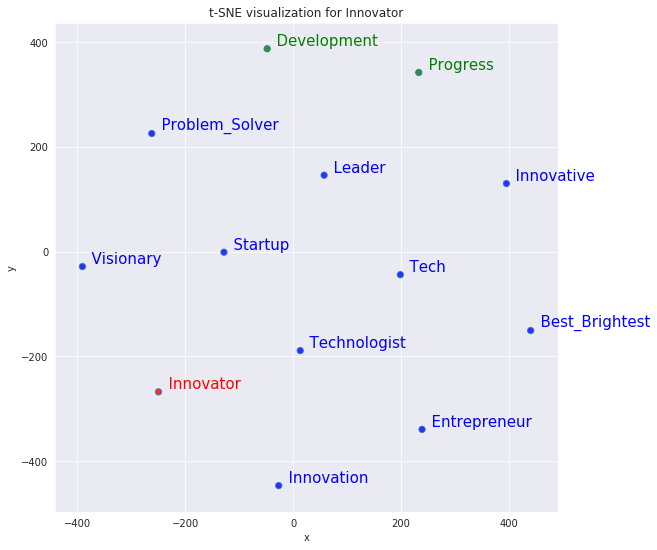

In [103]:
tsnescatterplot(w2v_model, 'innovator',['progress','development'])

Interestingly, the 10 most similar words to Homer ends up around him, so does Apu and (sideshow) Bob, two recurrent characters.

## 10 Most similar words vs. 10 Most dissimilar

This time, let's compare where the vector representation of Maggie and her 10 most similar words from the model lies compare to the vector representation of the 10 most dissimilar words to Maggie:

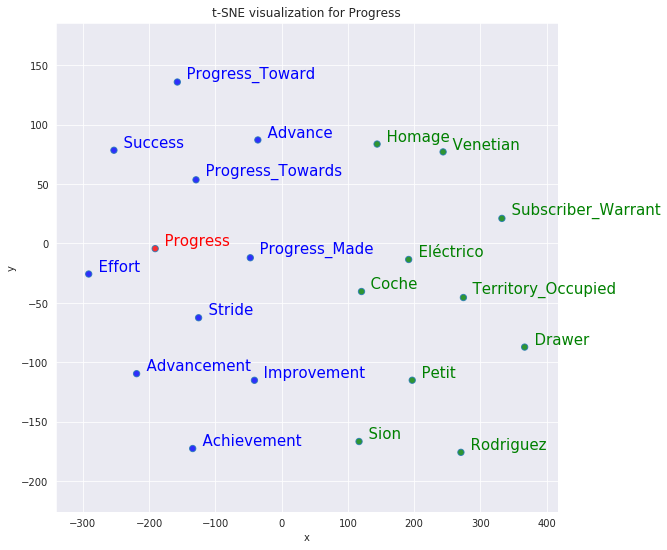

In [105]:
tsnescatterplot(w2v_model, 'progress', [i[0] for i in w2v_model.wv.most_similar(negative=["progress"])])

Neat! Maggie and her most similar words form a distinctive cluster from the most dissimilar words, it is a really encouraging plot!

## 10 Most similar words vs. 11th to 20th Most similar words:

Finally, we are going to plot the most similar words to Mr. Burns ranked 1st to 10th versus the ones ranked 11th to 20th:

(PS: Mr. Burns became mr_burn after the preprocessing)

In [ ]:
tsnescatterplot(w2v_model, "mr_burn", [t[0] for t in w2v_model.wv.most_similar(positive=["mr_burn"], topn=20)][10:])

As we can see, and that is very nice, all the 20 words are forming one cluster around Mr. Burns.

# Final Thoughts

I hope you found this tutorial useful and had as much fun reading it as I had writing it. Please do not hesitate to leave any comments, questions or suggestions you might have. See you around!

Also, please check [Supportiv](http://www.supportiv.com) around! (Simpson-ized logo)

<img src="https://fontmeme.com/permalink/180904/cc3d27a8aaa88189e764ee9d02331d0d.png" alt="drawing" width="500"/>


# Materials for more in depths understanding:
* Word Embeddings introduction: https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/
* Word2Vec introduction: https://skymind.ai/wiki/word2vec
* Another Word2Vec introduction: http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
* A great Gensim implentation tutorial: http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W467ScBjM2x
* Original articles from Mikolov et al.: https://arxiv.org/abs/1301.3781 and https://arxiv.org/abs/1310.4546


# Acknowledgements

* [Pouria Mojabi](https://www.linkedin.com/in/pouria-mojabi-1873615/), co-fouder of Supportiv Inc.

# References:
* [1]. Neural Net picture: McCormick, C. (2016, April 19). Word2Vec Tutorial - The Skip-Gram Model. Retrieved from http://www.mccormickml.com
* [2]. Aneesha Bakharia Medium article: https://medium.com/@aneesha/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229

# End